## Problem 0: Autopilot Implementation
### Low level control
Implement the `update(...)` functions in 
* `pd_control_with_rate.py`
* `pi_control.py`
* `tf_control.py` - Use the control discussed in class and not in the book

Tips / Instructions:
* Make sure that you saturate the return value to be limited based upon `self.limit`
* Note that `self.integrator` is the integral of the error and `self.error_delay_1` is the error on the previous loop through. Use the trapazoidal rule.
* An anti-windup piece of code is left in the PIControl to avoid integrator windup, causing the integrator to go down when the control is saturated.
* `y_delay_1` is the value of `y` at the previous step
* `u_delay_1` is the value of `u` at the previous step

### Autopilot
To implement the autopilot, calculate the gains in `control_parameters.py` and then in `autopilot.py` implement the following.
* `__init__(...)`: 
  * Use values from `control_parameters.py` (imported as `AP`) to initialize controllers for the sequential control loops in Chapter 6.1.
  * The controllers should be instances of `TFControl`, `PIControl`, and `PDControlWithRate`
* `update(...)`: Calculate the autopilot commands for $\delta_e$, $\delta_a$, $\delta_r$, and $\delta_t$ using successive loop closure

Tips / Instructions:
* `__init__(...)`
  * Limit the output of calculated roll from aileron to be between -45 an 45 degrees
  * Limit the output of calculated course angle from roll to be between -30 and 30 degrees
  * Limit the output of calculated pitch from elevevator to be between -45 and 45 degrees
  * Limit the output of calculated altitude from pitch to be between -30 and 30 degrees
  * Limit the output of the airspeed from throttle to be between -1 and 1
* `update(...)`
  * Saturate the commanded $\phi^c$ value between -30 degrees and 30 degrees before using it in the control loop
  * Saturate the commanded altitude to be within plus or minus Ap.altitude_zone of the current altitude
  * Do not allow negative thrust

Use of feedforward control:

You'll notice that the `MsgAutopilot` has a member called `phi_feedforward`. This feedforward term should be used when calculating $\phi^c$. The final equation in section 6.1.1.2 of the book has the equation
$$
\phi^c(t) = k_{p_\chi}\bigl(\chi^c(t) - \chi(t)\bigr) + k_{i_\chi} \int_{-\infty}^t\bigl(\chi^c(\tau) - \chi(\tau)\bigr)d\tau
$$
Implement it instead as
$$
\phi^c(t) = \phi_{ff} + k_{p_\chi}\bigl(\chi^c(t) - \chi(t)\bigr) + k_{i_\chi} \int_{-\infty}^t\bigl(\chi^c(\tau) - \chi(\tau)\bigr)d\tau
$$
where $\phi_{ff} = $ `cmd.phi_feedforward`

In [1]:
# Note that this cell can be run separately to initialize for other cell blocks
import numpy as np
from mav_sim.chap3.mav_dynamics import DynamicState
from mav_sim.chap6.run_sim import run_sim
from mav_sim.message_types.msg_sim_params import MsgSimParams
from mav_sim.tools.signals import Signals
from mav_sim.chap2.mav_viewer import MavViewer
from mav_sim.chap3.data_viewer import DataViewer
from mav_sim.tools.display_figures import display_data_view, display_mav_view
import mav_sim.parameters.aerosonde_parameters as MAV

# The viewers need to be initialized once due to restart issues with qtgraph
if 'mav_view' not in globals():
    print("Initializing mav_view")
    global mav_view
    mav_view = MavViewer()  # initialize the mav viewer
if 'data_view' not in globals():
    print("Initializing data_view")
    global data_view
    data_view = DataViewer()  # initialize view of data plots

# Initialize state values
sim_params = MsgSimParams(end_time=40., video_name="chap4.avi") # Sim ending in 10 seconds
state = DynamicState()

# Define nominal commands
Va_command_nom = Signals(dc_offset=MAV.Va0,
                        amplitude=0.0,
                        start_time=1000.0,
                        frequency=0.01)
altitude_command_nom = Signals(dc_offset=-MAV.down0,
                        amplitude=0.0,
                        start_time=1000.0,
                        frequency=0.02)
course_command_nom = Signals(dc_offset=MAV.psi0,
                        amplitude=0.,
                        start_time=1000.0,
                        frequency=0.015)

# Function for running simulation and displaying results
def run_sim_and_display(Va_command: Signals = Va_command_nom, altitude_command: Signals = altitude_command_nom, \
        course_command: Signals = course_command_nom):
    global mav_view
    global data_view
    data_view.reset(sim_params.start_time)
    (mav_view, data_view) = run_sim(sim=sim_params, init_state=state, mav_view=mav_view, data_view=data_view, \
        Va_command=Va_command, altitude_command=altitude_command, course_command=course_command) 
    display_data_view(data_view)
    display_mav_view(mav_view)


Initializing mav_view
Initializing data_view


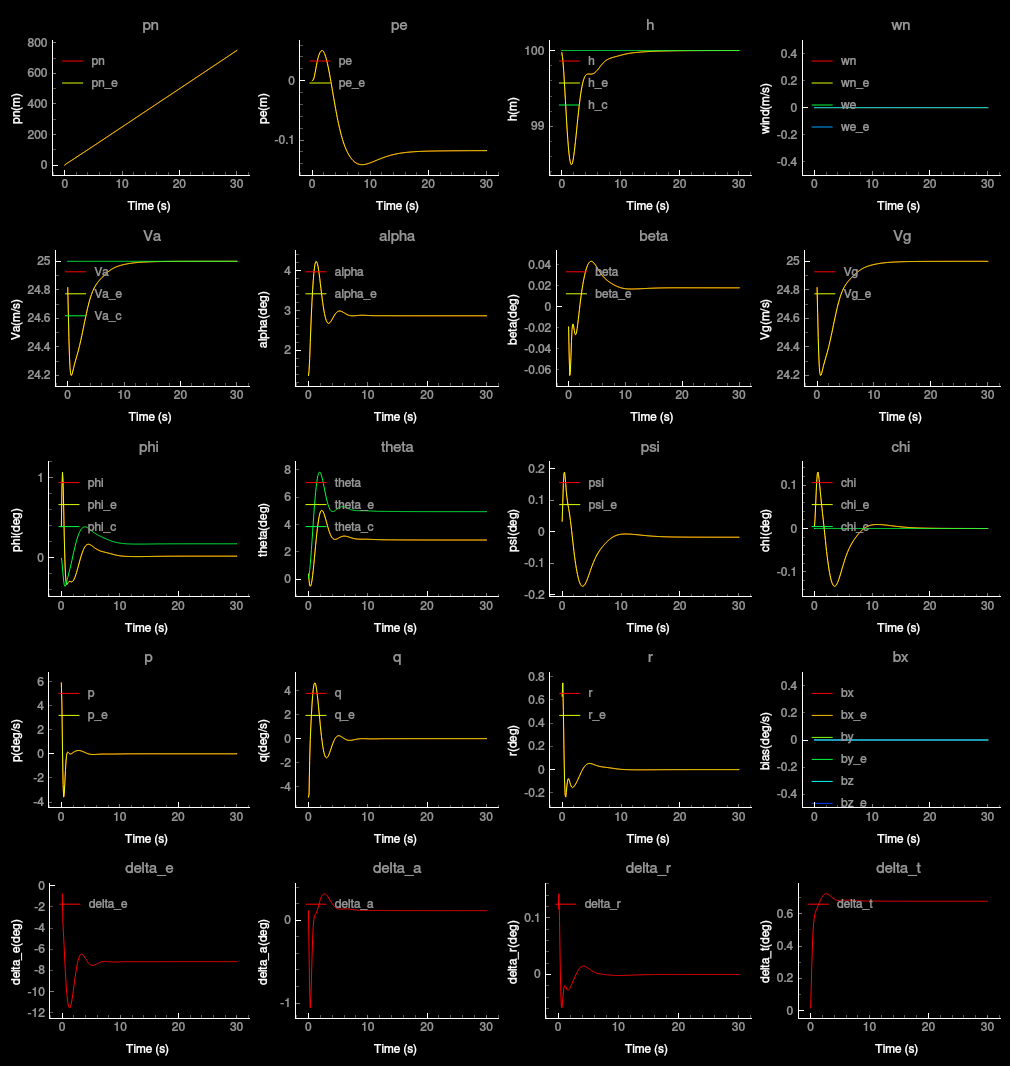

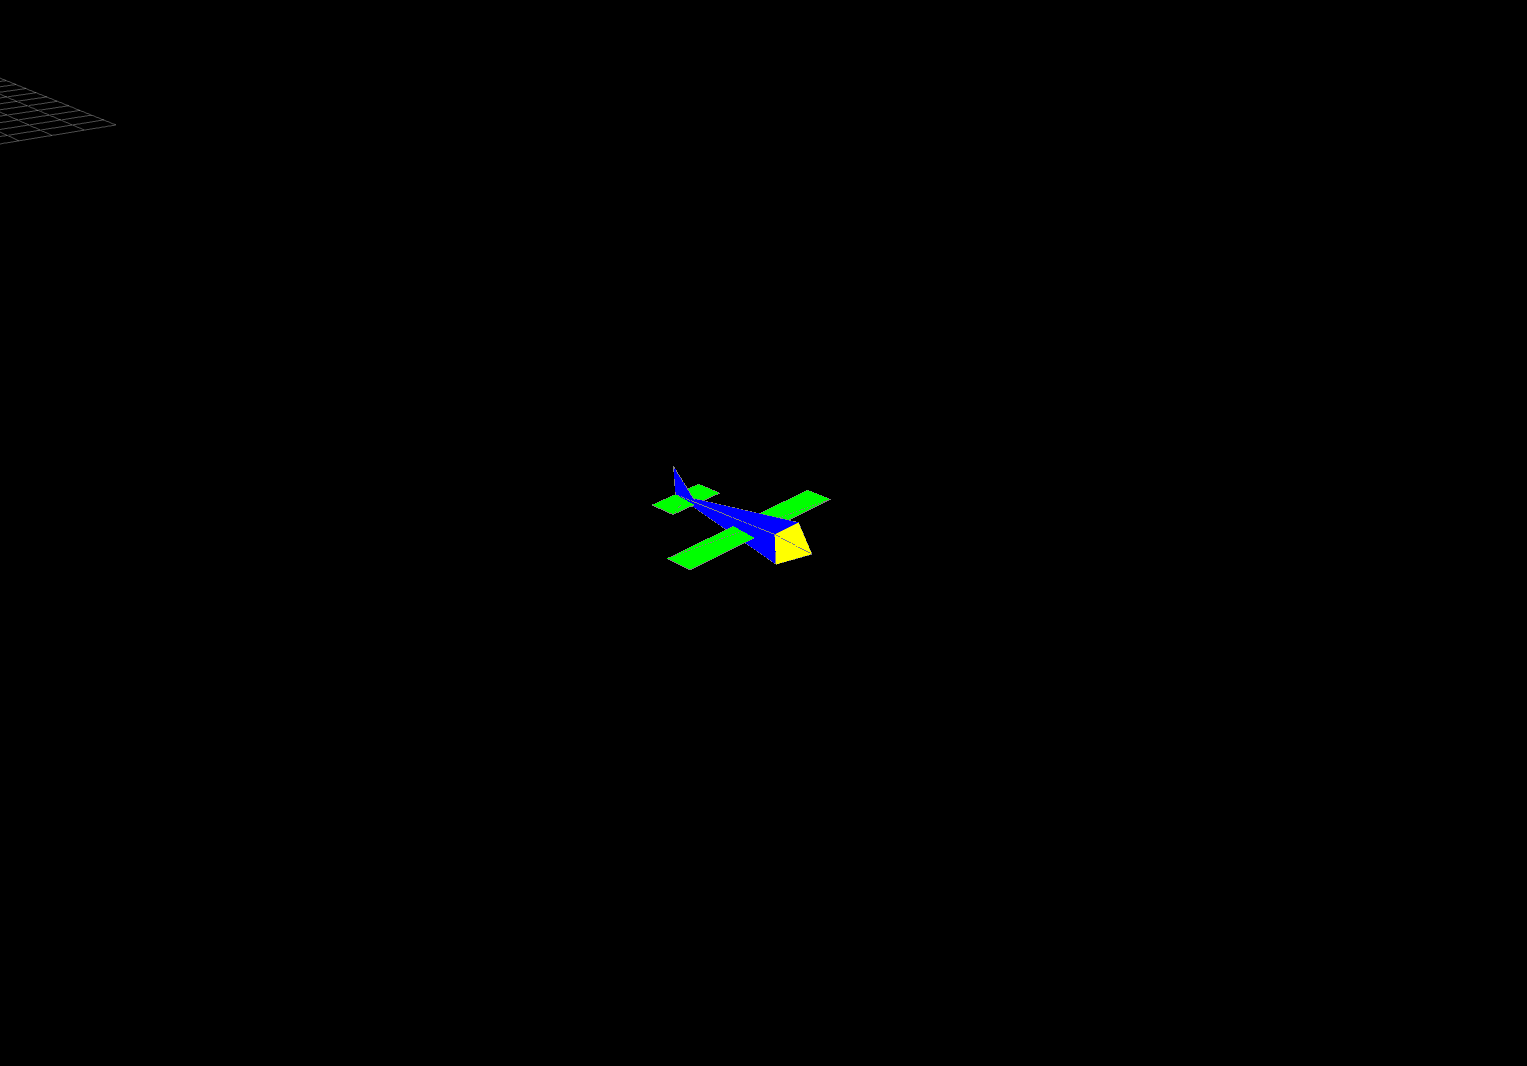

In [2]:
# Run a straight controlled trajectory
run_sim_and_display()

## Problem 1: Airspeed command - part a
Command the aircraft airspeed to oscillate between 32 and 38 every ten seconds with a starting time of 10.0.

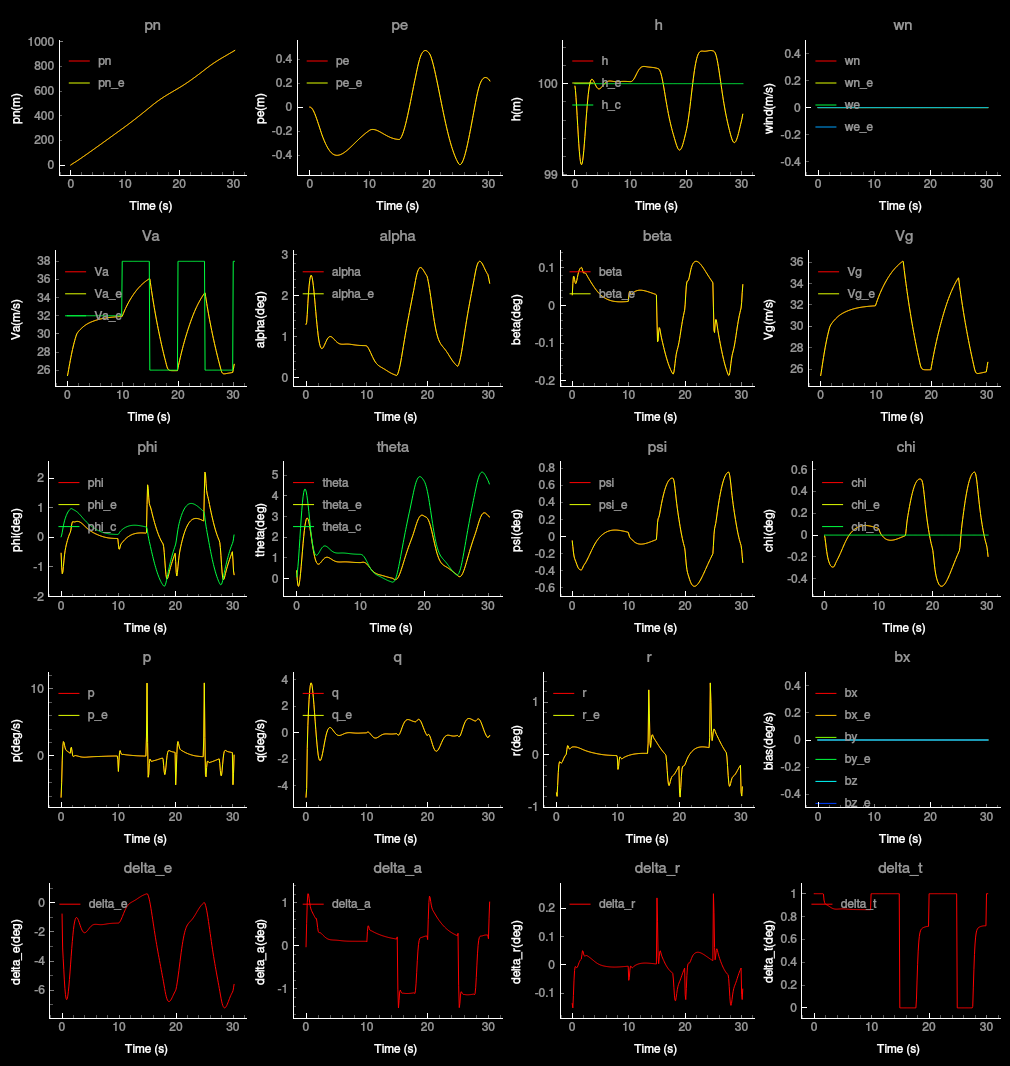

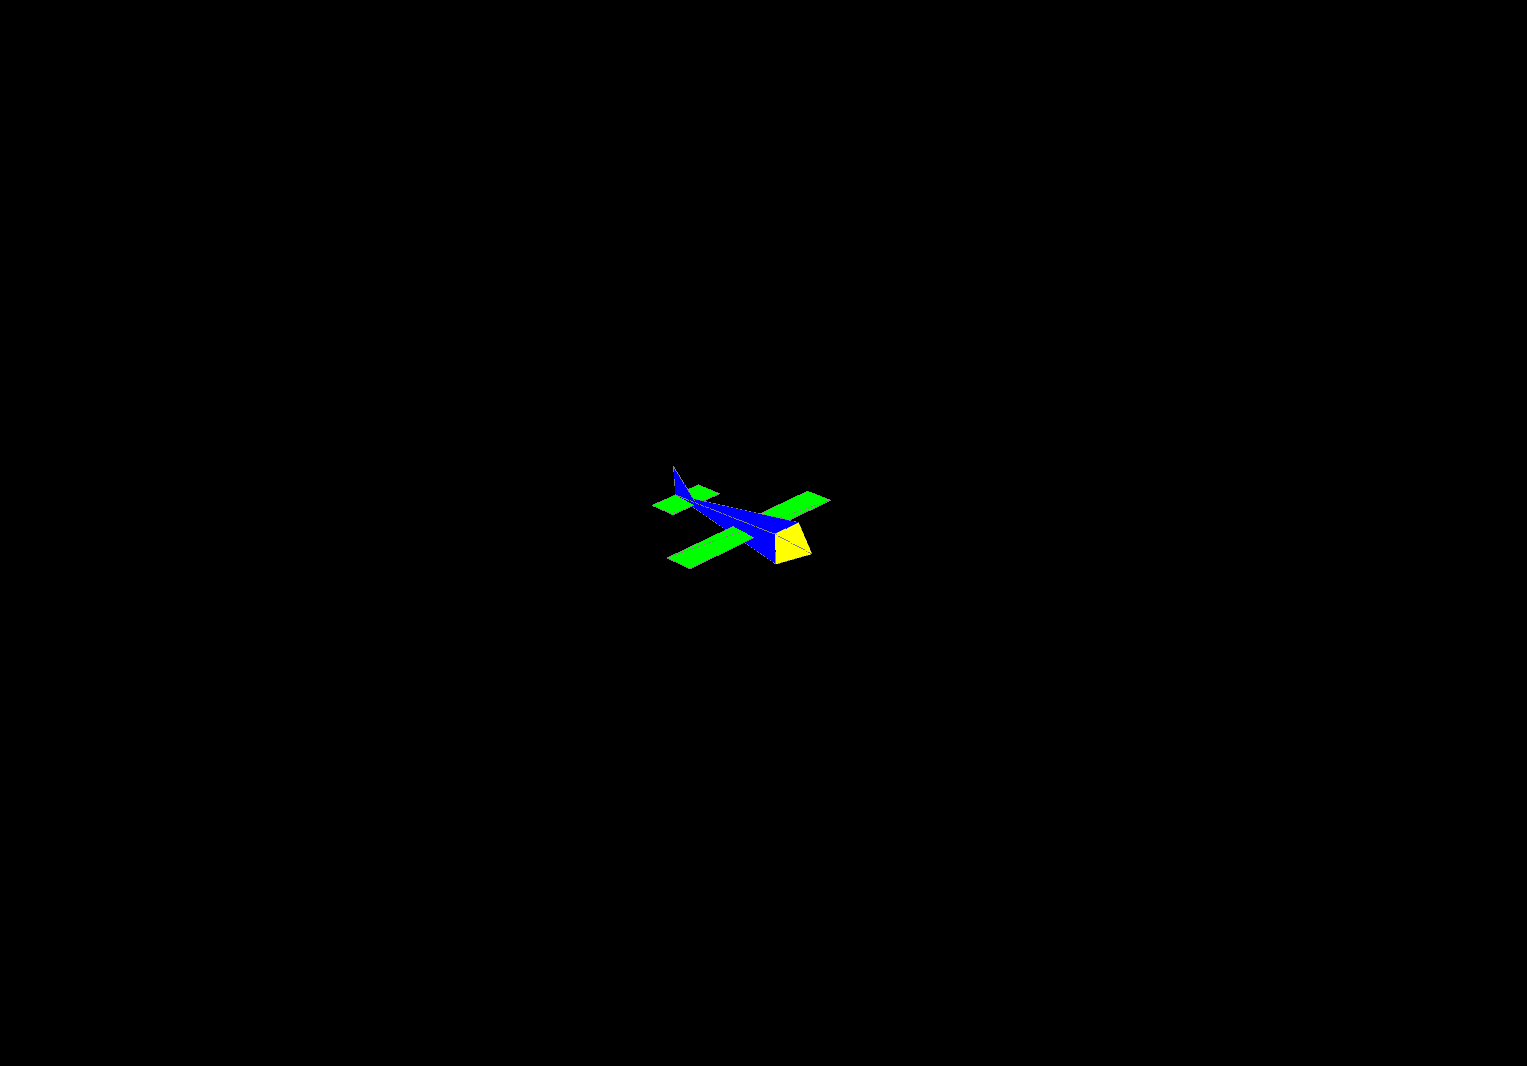

In [3]:
# Create the signal
Va_command = Signals(dc_offset=32.0,
                        amplitude=6.0,
                        start_time=10.0,
                        frequency=0.1)

# Run the simulation
run_sim_and_display(Va_command=Va_command)

## Problem 2: Airspeed command - part b
Command the aircraft airspeed to oscillate between 20 and 26 every ten seconds with a starting time of 10.0.

### Question: What difference do you notice in the results? Describe the reason behind the major difference.
Answer: 

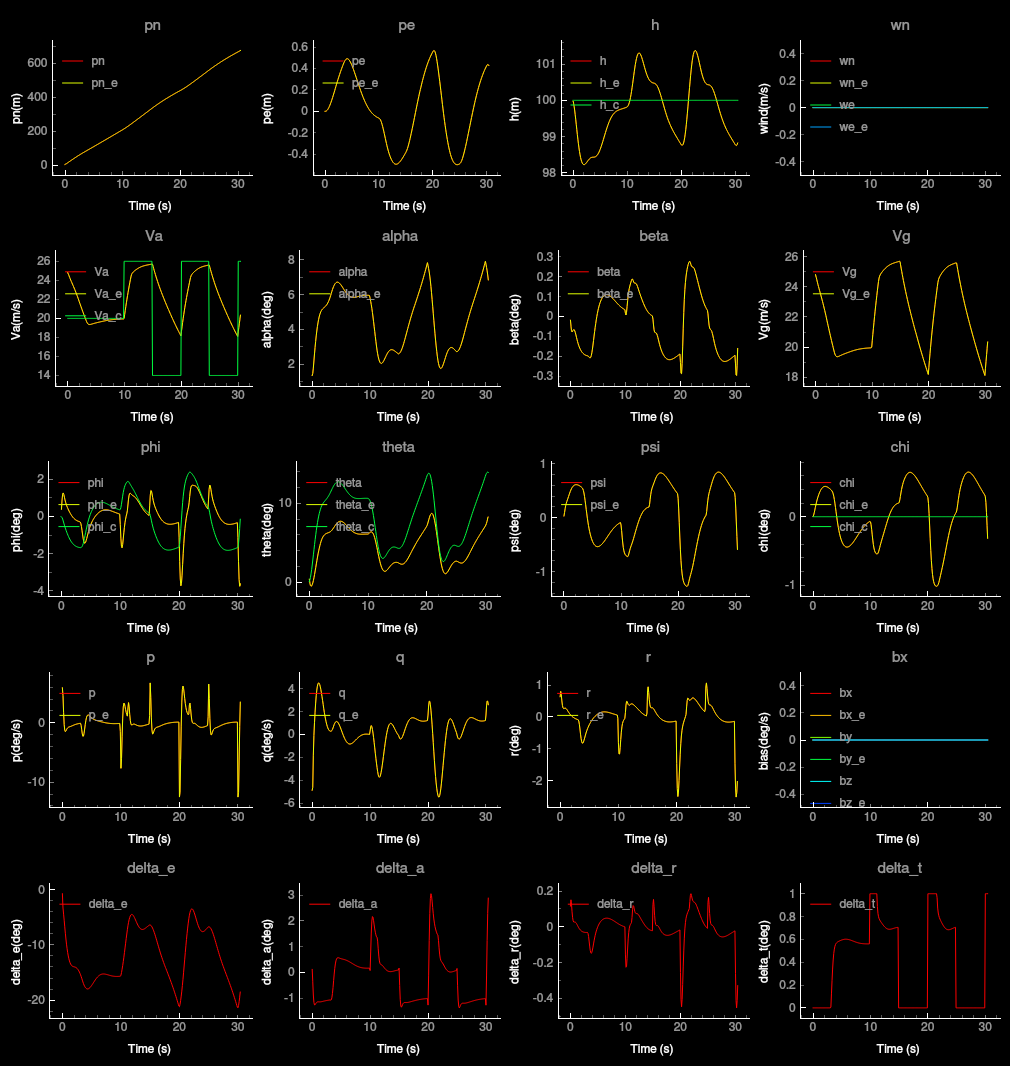

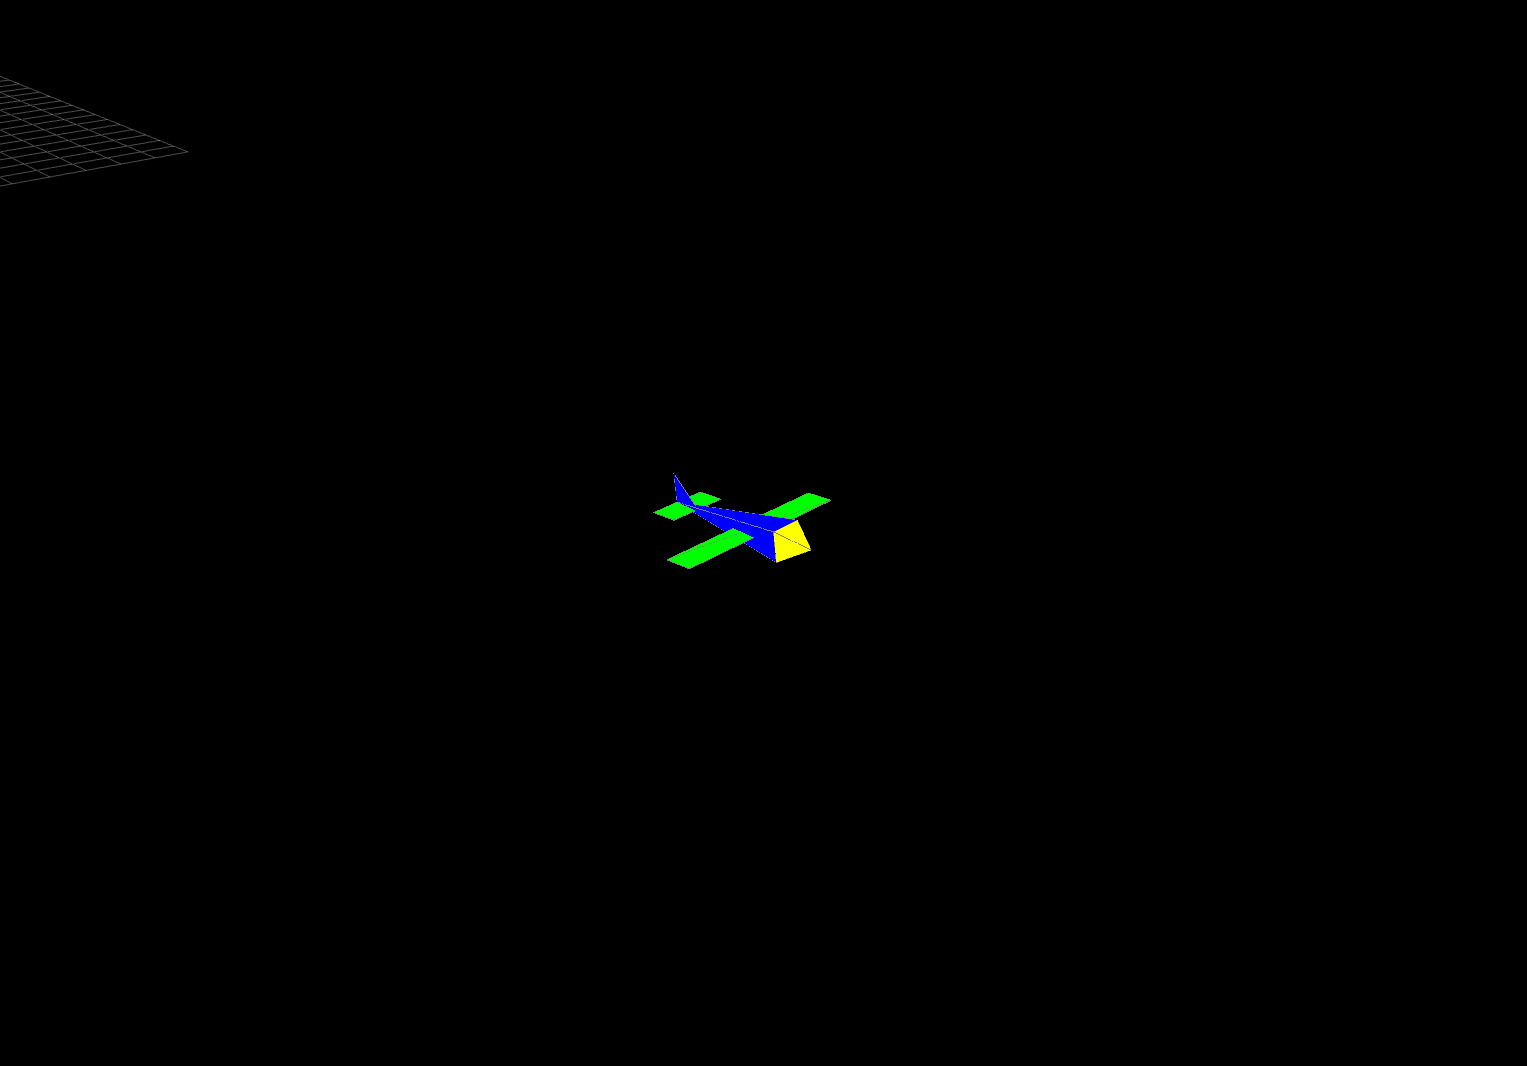

In [4]:
# Create the signal
Va_command = Signals(dc_offset=20.0,
                        amplitude=6.0,
                        start_time=10.0,
                        frequency=0.1)

# Run the simulation
run_sim_and_display(Va_command=Va_command)

## Problem 3: Altitude
Command the aircraft altitude to oscillate between 80 and 100 every 20 seconds starting at time 10.0.

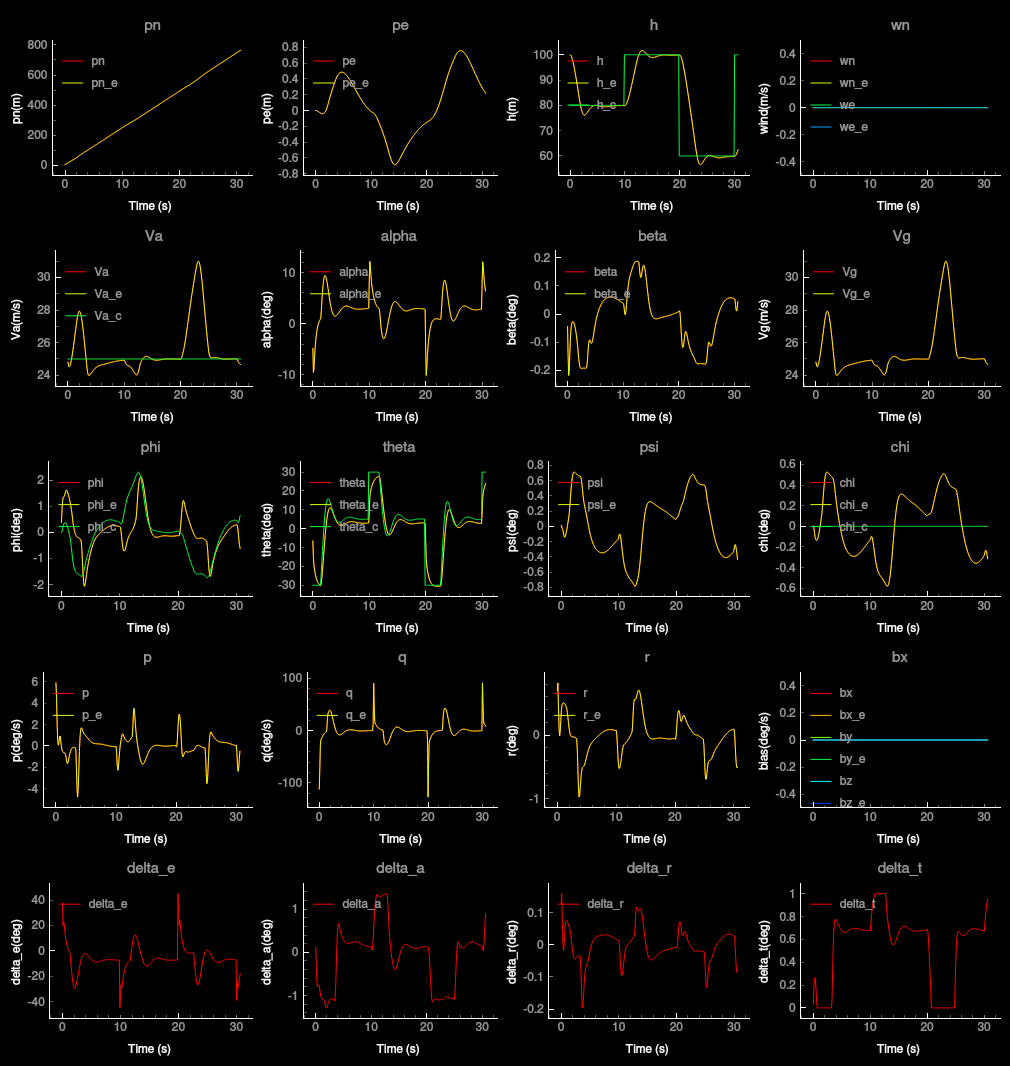

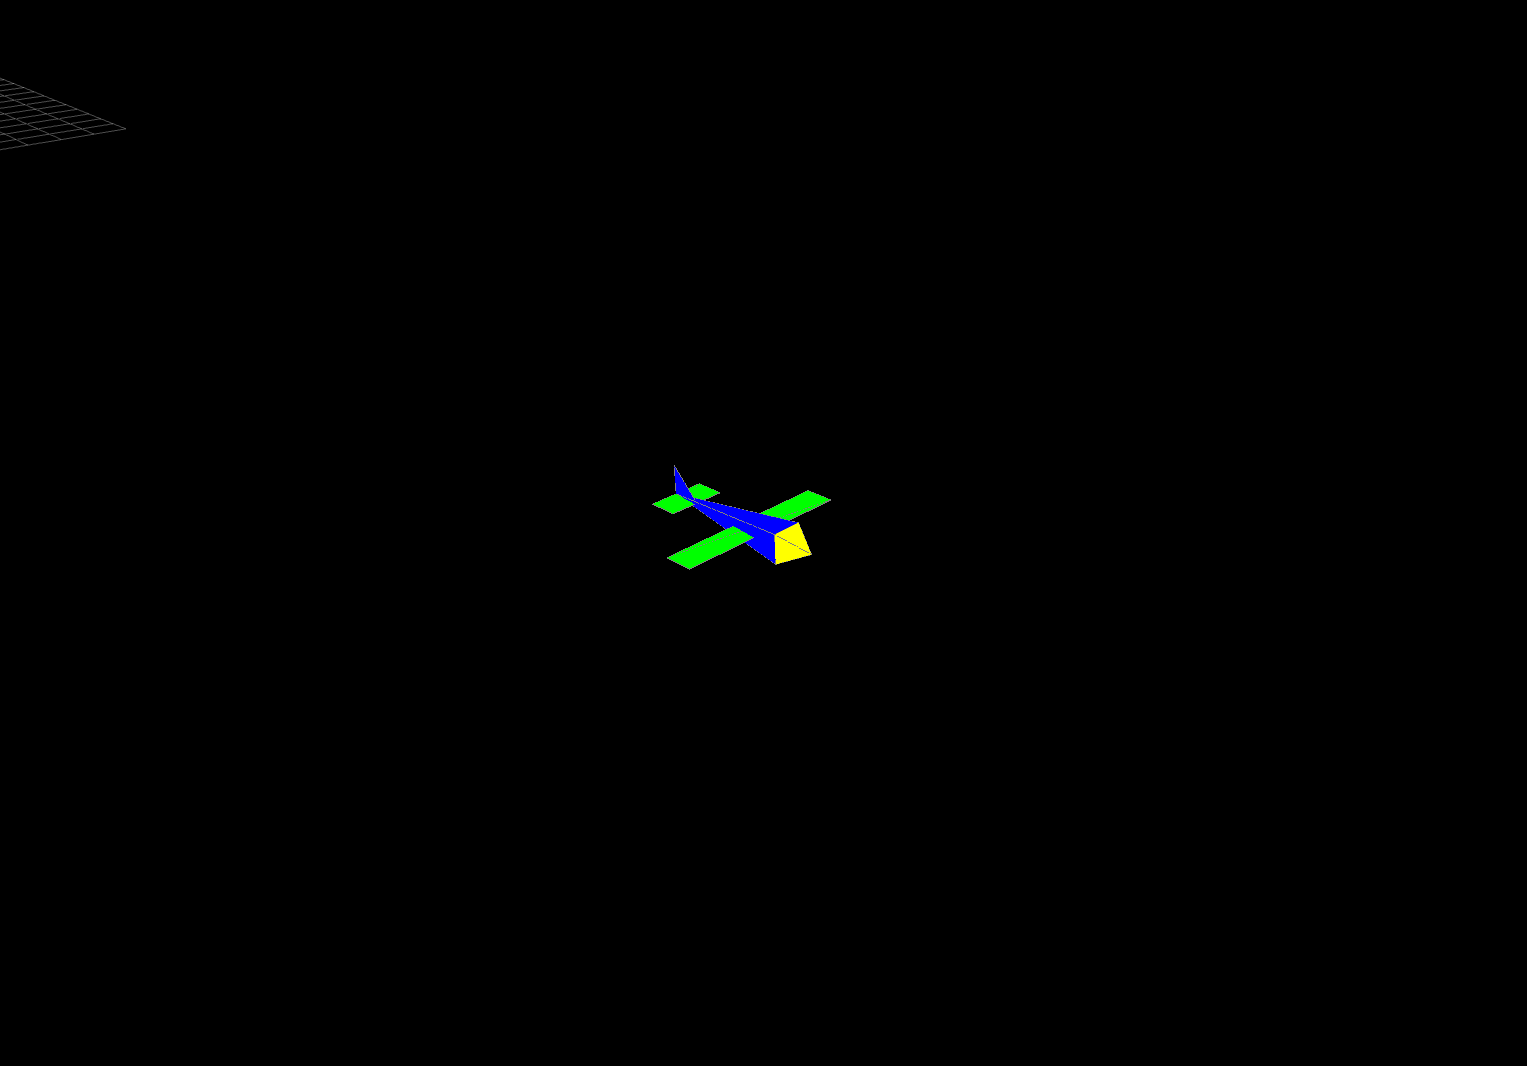

In [5]:
altitude_command = Signals(dc_offset=80.0,
                        amplitude=20.0,
                        start_time=10.0,
                        frequency=0.05)


# Run the simulation
run_sim_and_display(altitude_command=altitude_command)

## Problem 4: Course
Command the aircraft course to move between 60 degrees and 80 degrees every 10 seconds starting at time 10.0.

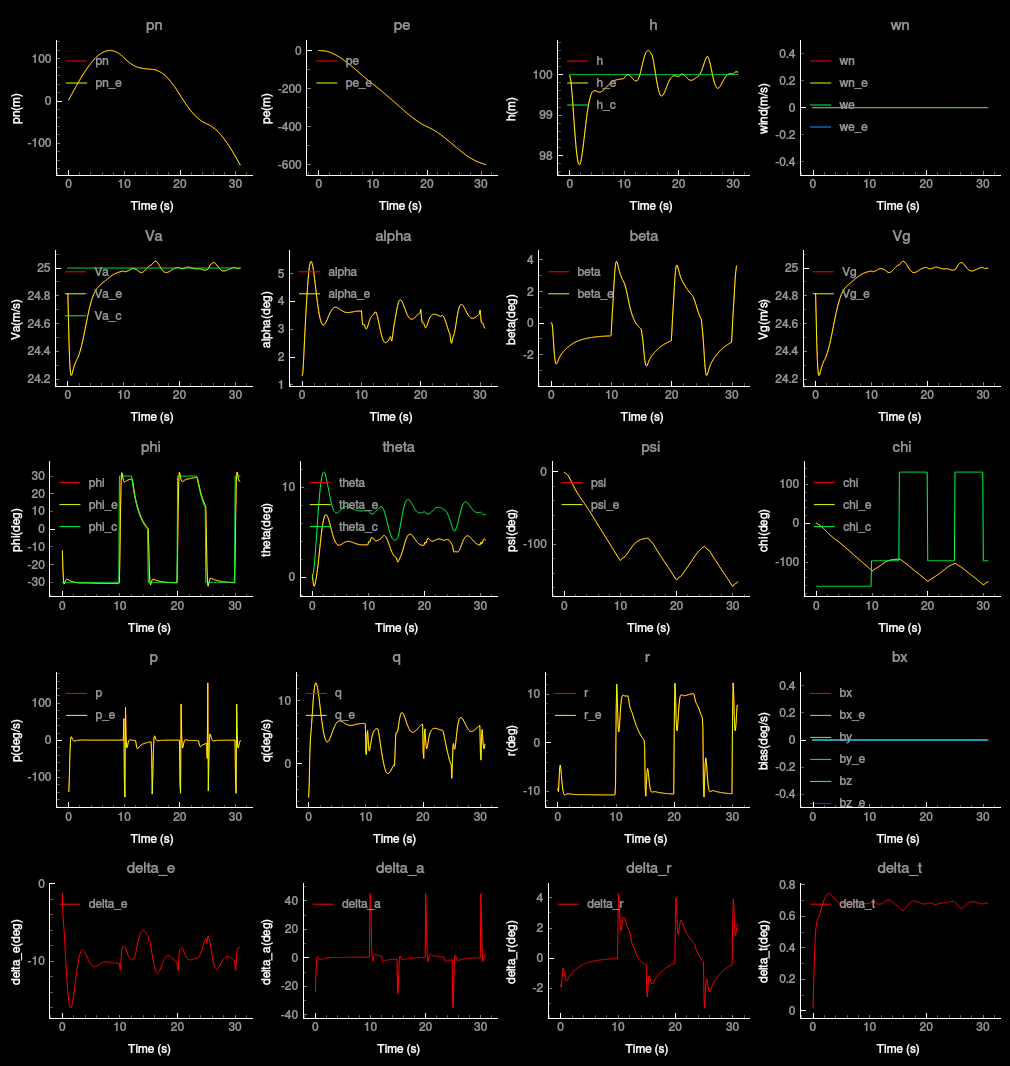

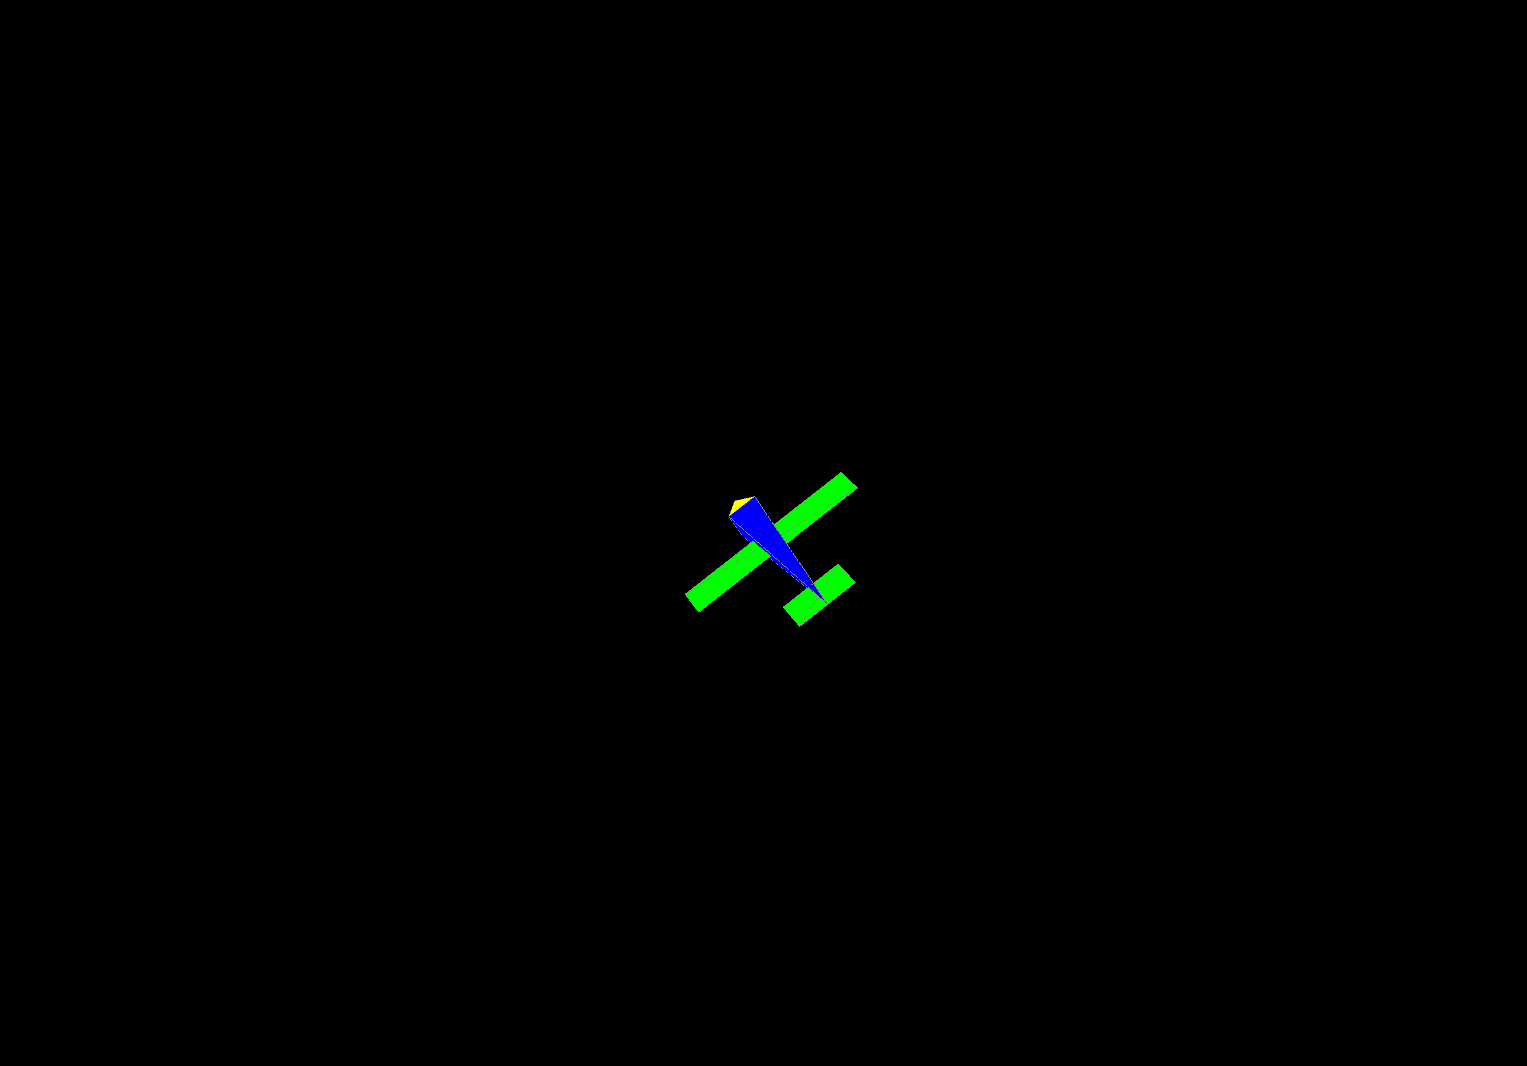

In [6]:
course_command = Signals(dc_offset=60.0,
                        amplitude=20.0,
                        start_time=10.0,
                        frequency=0.1)


# Run the simulation
run_sim_and_display(course_command=course_command)

## Simple code checking
The following code does not need to change. It should just be used as a sanity check so that you know the code is implemented properly. The output should not have any lines reading `Failed test!`

In [7]:
from mav_sim.unit_tests.ch6_feedback_control_test import run_all_tests
run_all_tests()

Starting pd_control_with_rate test

Calculated output:
0.0
Expected output:
0.0
Passed test
Calculated output:
-0.43974730752905633
Expected output:
-0.43974730752905633
Passed test
End of test

Starting pi_control test

Calculated output:
0.0
Expected output:
0.0
Passed test
Calculated output:
-0.5235987755982988
Expected output:
-0.5235987755982988
Passed test
End of test

Starting tf_control test

Calculated output:
0.0
Expected output:
0.0
Passed test
Calculated output:
0.794620186396522
Expected output:
0.794620186396522
Passed test
End of test

Starting autopilot test

Calculated MsgDelta:
elevator= 0.0 aileron= 0.0 rudder= 0.0 throttle= 0.0
Expected MsgDelta:
elevator= 0 aileron= 0 rudder= 0 throttle= 0
Passed test
Calculated MsgState:
north= 0 east= 0 altitude= 0.0 phi= 0.0 theta= 0.0 psi= 0 Va= 0.0 alpha= 0 beta= 0 p= 0 q= 0 r= 0 Vg= 0 gamma= 0 chi= 0.0 wn= 0 we= 0 bx= 0 by= 0 bz= 0
Expected MsgState:
north= 0 east= 0 altitude= 0 phi= 0 theta= 0 psi= 0 Va= 0 alpha= 0 beta= 0 p